# PART 1

In [ ]:
import os
import pickle
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import tqdm

IMAGE_DIR = "/kaggle/input/datasets/adityajn105/flickr30k/Images"
OUTPUT_FILE = 'flickr30k_features.pkl'

class FlickrDataset(Dataset):
    def __init__(self, img_dir, transform):
        self.img_names = [
            f for f in os.listdir(img_dir)
            if f.endswith(('.jpg', '.jpeg'))
        ]
        self.transform = transform
        self.img_dir = img_dir

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, name)
        img = Image.open(img_path).convert('RGB')
        return self.transform(img), name


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model = nn.Sequential(*list(model.children())[:-1])
model = nn.DataParallel(model).to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        (0.485, 0.456, 0.406),
        (0.229, 0.224, 0.225)
    )
])

dataset = FlickrDataset(IMAGE_DIR, transform)
loader = DataLoader(dataset, batch_size=128, num_workers=4)

features_dict = {}

print("images:", IMAGE_DIR)

with torch.no_grad():
    for imgs, names in tqdm(loader, desc="Extracting Features"):
        feats = model(imgs.to(device)).view(imgs.size(0), -1)
        for i, name in enumerate(names):
            features_dict[name] = feats[i].cpu().numpy()

with open(OUTPUT_FILE, 'wb') as f:
    pickle.dump(features_dict, f)

print(f"{len(features_dict)} images processed and saved to {OUTPUT_FILE}")

images: /kaggle/input/datasets/adityajn105/flickr30k/Images


Extracting Features: 100%|██████████| 249/249 [01:26<00:00,  2.88it/s]


31783 images processed and saved to flickr30k_features.pkl


# Part 2

In [38]:
import string
from collections import Counter
import numpy as np
import pandas as pd

In [39]:

CAPTIONS_FILE = "/kaggle/input/datasets/adityajn105/flickr30k/captions.txt"
df = pd.read_csv(CAPTIONS_FILE)  # reads CSV safely (handles quoted captions)
print("Rows:", len(df))
print(df.head())

    

Rows: 158915
            image                                            caption
0  1000092795.jpg   Two young guys with shaggy hair look at their...
1  1000092795.jpg   Two young , White males are outside near many...
2  1000092795.jpg   Two men in green shirts are standing in a yard .
3  1000092795.jpg       A man in a blue shirt standing in a garden .
4  1000092795.jpg            Two friends enjoy time spent together .


In [40]:
image_captions = {}

for _, row in df.iterrows():
    img = str(row["image"]).strip()
    cap = str(row["caption"]).strip()

    if img not in image_captions:
        image_captions[img] = []

    image_captions[img].append(cap)

print("Total unique images:", len(image_captions))
first_img = list(image_captions.keys())[0]
print("Example image:", first_img)
print("Example captions:", image_captions[first_img])

Total unique images: 31783
Example image: 1000092795.jpg
Example captions: ['Two young guys with shaggy hair look at their hands while hanging out in the yard .', 'Two young , White males are outside near many bushes .', 'Two men in green shirts are standing in a yard .', 'A man in a blue shirt standing in a garden .', 'Two friends enjoy time spent together .']


In [ ]:
def clean_caption(caption: str) -> str:
    caption = caption.lower().strip()
    caption = caption.translate(str.maketrans("", "", string.punctuation))
    caption = " ".join(caption.split())
    return caption

for img in image_captions:
    image_captions[img] = [clean_caption(c) for c in image_captions[img]]

print("Cleaned example:", image_captions[first_img])

START_TOKEN = "<start>"
END_TOKEN   = "<end>"
PAD_TOKEN   = "<pad>"
UNK_TOKEN   = "<unk>"

for img in image_captions:
    image_captions[img] = [
        f"{START_TOKEN} {c} {END_TOKEN}" for c in image_captions[img]
    ]

print("\n\n\n\n With tokens:", image_captions[first_img])

Cleaned example: ['two young guys with shaggy hair look at their hands while hanging out in the yard', 'two young white males are outside near many bushes', 'two men in green shirts are standing in a yard', 'a man in a blue shirt standing in a garden', 'two friends enjoy time spent together']




 With tokens: ['<start> two young guys with shaggy hair look at their hands while hanging out in the yard <end>', '<start> two young white males are outside near many bushes <end>', '<start> two men in green shirts are standing in a yard <end>', '<start> a man in a blue shirt standing in a garden <end>', '<start> two friends enjoy time spent together <end>']


In [ ]:
special_tokens = {PAD_TOKEN, UNK_TOKEN, START_TOKEN, END_TOKEN}

word_counts = Counter()

for caps in image_captions.values():
    for cap in caps:
        for w in cap.split():
            if w not in special_tokens:
                word_counts[w] += 1

print("Total unique NON-special words found:", len(word_counts))
print("Most common NON-special words:", word_counts.most_common(10))

Total unique NON-special words found: 20009
Most common NON-special words: [('a', 271704), ('in', 83466), ('the', 62978), ('on', 45669), ('and', 44263), ('man', 42598), ('is', 41117), ('of', 38776), ('with', 36207), ('woman', 22211)]


In [ ]:
MIN_WORD_FREQ = 4

vocab_words = [w for w, f in word_counts.items() if f >= MIN_WORD_FREQ]

vocab = [PAD_TOKEN, UNK_TOKEN, START_TOKEN, END_TOKEN] + vocab_words

word2idx = {w: i for i, w in enumerate(vocab)}
idx2word = {i: w for w, i in word2idx.items()}

print("Vocabulary size:", len(vocab))
print("Token IDs:")
print("PAD:", word2idx[PAD_TOKEN], "UNK:", word2idx[UNK_TOKEN],
      "START:", word2idx[START_TOKEN], "END:", word2idx[END_TOKEN])

Vocabulary size: 8629
Token IDs:
PAD: 0 UNK: 1 START: 2 END: 3


In [ ]:
PAD_IDX = word2idx[PAD_TOKEN]
UNK_IDX = word2idx[UNK_TOKEN]

def caption_to_ids(caption: str) -> list:
    ids = []
    for w in caption.split():
        ids.append(word2idx.get(w, UNK_IDX))
    return ids

In [ ]:
max_len_in_data = 0
for caps in image_captions.values():
    for cap in caps:
        max_len_in_data = max(max_len_in_data, len(cap.split()))

print("Max caption length in dataset:", max_len_in_data)

MAX_LEN = min(max_len_in_data, 40)
print("Using MAX_LEN:", MAX_LEN)

Max caption length in dataset: 80
Using MAX_LEN: 40


In [ ]:
def pad_or_truncate(ids: list, max_len: int) -> list:
    if len(ids) > max_len:
        return ids[:max_len]
    return ids + [PAD_IDX] * (max_len - len(ids))


data = []
skipped = 0

for img, caps in image_captions.items():
    for cap in caps:
        ids = caption_to_ids(cap)
        ids = pad_or_truncate(ids, MAX_LEN)

        if len(ids) < 2:
            skipped += 1
            continue

        input_seq = ids[:-1]
        target_seq = ids[1:]

        data.append((img, input_seq, target_seq))

print("Total samples:", len(data))
print("Skipped (too short):", skipped)

sample_img, sample_inp, sample_tgt = data[0]
print("\nExample image:", sample_img)
print("Input IDs (first 20):", sample_inp[:20])
print("Target IDs (first 20):", sample_tgt[:20])
print("Pad count in input:", sample_inp.count(PAD_IDX))
print("UNK count in input:", sample_inp.count(UNK_IDX))

vocab_data = {
    'word2idx': word2idx,
    'idx2word': idx2word
}
with open('vocab.pkl', 'wb') as f:
    pickle.dump(vocab_data, f)
print("Saved vocab.pkl")

Total samples: 158915
Skipped (too short): 0

Example image: 1000092795.jpg
Input IDs (first 20): [2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 3, 0, 0]
Target IDs (first 20): [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 3, 0, 0, 0]
Pad count in input: 21
UNK count in input: 0
Saved vocab.pkl


# Part 3

In [47]:
import random

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

FEATURES_PKL_PATH = "/kaggle/working/flickr30k_features.pkl"

with open(FEATURES_PKL_PATH, "rb") as f:
    features_dict = pickle.load(f)

print("Total images in features:", len(features_dict))
one_key = next(iter(features_dict.keys()))
print("Example key:", one_key)
print("Example feature shape:", np.array(features_dict[one_key]).shape)

Using device: cuda
Total images in features: 31783
Example key: 2715746315.jpg
Example feature shape: (2048,)


In [ ]:
def normalize_image_key(k: str) -> str:
    return os.path.basename(str(k))

features_dict_norm = {}
for k, v in features_dict.items():
    features_dict_norm[normalize_image_key(k)] = v

features_dict = features_dict_norm
print("Normalized features keys example:", next(iter(features_dict.keys())))

Normalized features keys example: 2715746315.jpg


In [50]:
all_images = sorted(list({img for img, _, _ in data}))
random.seed(42)
random.shuffle(all_images)

n = len(all_images)
train_imgs = set(all_images[:int(0.80*n)])
val_imgs   = set(all_images[int(0.80*n):int(0.90*n)])
test_imgs  = set(all_images[int(0.90*n):])

train_data, val_data, test_data = [], [], []

for sample in data:
    img = sample[0]
    if img in train_imgs:
        train_data.append(sample)
    elif img in val_imgs:
        val_data.append(sample)
    else:
        test_data.append(sample)

print("Train samples:", len(train_data))
print("Val samples:", len(val_data))
print("Test samples:", len(test_data))


Train samples: 127130
Val samples: 15890
Test samples: 15895


In [ ]:
class FlickrCaptionDataset(Dataset):
    def __init__(self, samples, features_dict):
        self.samples = samples
        self.features = features_dict

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img, inp, tgt = self.samples[idx]

        feat = self.features[img]
        feat = torch.tensor(feat, dtype=torch.float32)

        inp = torch.tensor(inp, dtype=torch.long)
        tgt = torch.tensor(tgt, dtype=torch.long)

        return feat, inp, tgt

In [ ]:
BATCH_SIZE = 128

train_ds = FlickrCaptionDataset(train_data, features_dict)
val_ds   = FlickrCaptionDataset(val_data, features_dict)
test_ds  = FlickrCaptionDataset(test_data, features_dict)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("DataLoaders ready.")

DataLoaders ready.


In [ ]:
class Encoder(nn.Module):
    def __init__(self, feature_dim=2048, hidden_size=512):
        super().__init__()
        self.fc = nn.Linear(feature_dim, hidden_size)
        self.act = nn.Tanh()

    def forward(self, features):
        h = self.act(self.fc(features))
        h = h.unsqueeze(0)
        return h


class DecoderGRU(nn.Module):
    def __init__(self, vocab_size, embed_dim=256, hidden_size=512, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.gru = nn.GRU(embed_dim, hidden_size, batch_first=True)
        self.fc_out = nn.Linear(hidden_size, vocab_size)

    def forward(self, input_seq, hidden):
        emb = self.embedding(input_seq)
        out, hidden = self.gru(emb, hidden)
        logits = self.fc_out(out)
        return logits, hidden

    def decode_step(self, token, hidden):
        emb = self.embedding(token).unsqueeze(1)
        out, hidden = self.gru(emb, hidden)
        logits = self.fc_out(out.squeeze(1))
        return logits, hidden

In [ ]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, vocab_size, pad_idx, feature_dim=2048, hidden_size=512, embed_dim=256):
        super().__init__()
        self.encoder = Encoder(feature_dim=feature_dim, hidden_size=hidden_size)
        self.decoder = DecoderGRU(vocab_size=vocab_size, embed_dim=embed_dim, hidden_size=hidden_size, pad_idx=pad_idx)

    def forward(self, features, input_seq):
        hidden = self.encoder(features)
        logits, _ = self.decoder(input_seq, hidden)
        return logits

In [55]:
vocab_size = len(word2idx)

HIDDEN_SIZE = 512
EMBED_DIM   = 256

model = ImageCaptioningModel(
    vocab_size=vocab_size,
    pad_idx=PAD_IDX,
    feature_dim=2048,
    hidden_size=HIDDEN_SIZE,
    embed_dim=EMBED_DIM
).to(device)

print(model)


ImageCaptioningModel(
  (encoder): Encoder(
    (fc): Linear(in_features=2048, out_features=512, bias=True)
    (act): Tanh()
  )
  (decoder): DecoderGRU(
    (embedding): Embedding(8629, 256, padding_idx=0)
    (gru): GRU(256, 512, batch_first=True)
    (fc_out): Linear(in_features=512, out_features=8629, bias=True)
  )
)


In [56]:
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


# Part 4

In [ ]:
def train_one_epoch(model, loader, optimizer, criterion, device, clip_grad=1.0):
    model.train()
    total_loss = 0.0
    total_tokens = 0

    for features, inp, tgt in loader:
        features = features.to(device)
        inp = inp.to(device)
        tgt = tgt.to(device)

        optimizer.zero_grad()

        logits = model(features, inp)

        B, T, V = logits.shape
        logits_flat = logits.reshape(B * T, V)
        tgt_flat = tgt.reshape(B * T)

        loss = criterion(logits_flat, tgt_flat)

        loss.backward()

        if clip_grad is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)

        optimizer.step()

        total_loss += loss.item()

        non_pad = (tgt_flat != PAD_IDX).sum().item()
        total_tokens += non_pad

    avg_loss = total_loss / max(1, len(loader))
    return avg_loss

In [ ]:
@torch.no_grad()
def validate_one_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0

    for features, inp, tgt in loader:
        features = features.to(device)
        inp = inp.to(device)
        tgt = tgt.to(device)

        logits = model(features, inp)
        B, T, V = logits.shape

        logits_flat = logits.reshape(B * T, V)
        tgt_flat = tgt.reshape(B * T)

        loss = criterion(logits_flat, tgt_flat)
        total_loss += loss.item()

    avg_loss = total_loss / max(1, len(loader))
    return avg_loss

In [ ]:
EPOCHS = 10
CLIP_GRAD = 1.0

best_val_loss = float("inf")
best_model_path = "best_caption_model.pt"

train_losses = []
val_losses = []

In [61]:
for epoch in range(1, EPOCHS + 1):
    train_loss = train_one_epoch(
        model=model,
        loader=train_loader,
        optimizer=optimizer,
        criterion=criterion,
        device=device,
        clip_grad=CLIP_GRAD
    )

    val_loss = validate_one_epoch(
        model=model,
        loader=val_loader,
        criterion=criterion,
        device=device
    )

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch:02d}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved best model (val_loss={best_val_loss:.4f})")


Epoch 01/10 | Train Loss: 3.5203 | Val Loss: 3.0888
Saved best model (val_loss=3.0888)
Epoch 02/10 | Train Loss: 2.8054 | Val Loss: 2.9642
Saved best model (val_loss=2.9642)
Epoch 03/10 | Train Loss: 2.5469 | Val Loss: 2.9447
Saved best model (val_loss=2.9447)
Epoch 04/10 | Train Loss: 2.3590 | Val Loss: 2.9650
Epoch 05/10 | Train Loss: 2.2045 | Val Loss: 3.0132
Epoch 06/10 | Train Loss: 2.0739 | Val Loss: 3.0673
Epoch 07/10 | Train Loss: 1.9615 | Val Loss: 3.1325
Epoch 08/10 | Train Loss: 1.8637 | Val Loss: 3.1934
Epoch 09/10 | Train Loss: 1.7785 | Val Loss: 3.2682
Epoch 10/10 | Train Loss: 1.7035 | Val Loss: 3.3362


In [62]:
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()
print("Loaded model")


Loaded model


In [ ]:
import torch
import torch.nn.functional as F

START_TOKEN = "<start>"
END_TOKEN = "<end>"
PAD_TOKEN = "<pad>"
UNK_TOKEN = "<unk>"

START_ID = word2idx[START_TOKEN]
END_ID   = word2idx[END_TOKEN]
PAD_ID   = word2idx[PAD_TOKEN]
UNK_ID   = word2idx[UNK_TOKEN]

def ids_to_caption(ids, idx2word):
    words = []
    for i in ids:
        w = idx2word.get(int(i), UNK_TOKEN)
        if w == END_TOKEN:
            break
        if w in [START_TOKEN, PAD_TOKEN]:
            continue
        words.append(w)
    return " ".join(words)

In [ ]:
@torch.no_grad()
def generate_caption_greedy(model, feature_vec, max_len=40):
    model.eval()

    if feature_vec.dim() == 1:
        feature_vec = feature_vec.unsqueeze(0)
    feature_vec = feature_vec.to(device)

    hidden = model.encoder(feature_vec)

    token = torch.tensor([START_ID], device=device, dtype=torch.long)

    generated_ids = [START_ID]

    for _ in range(max_len):
        logits, hidden = model.decoder.decode_step(token, hidden)
        next_id = int(torch.argmax(logits, dim=-1).item())

        generated_ids.append(next_id)

        if next_id == END_ID:
            break

        token = torch.tensor([next_id], device=device, dtype=torch.long)

    return ids_to_caption(generated_ids, idx2word)

In [ ]:
@torch.no_grad()
def generate_caption_beam(model, feature_vec, max_len=40, k=3, length_penalty=0.7):
    model.eval()

    if feature_vec.dim() == 1:
        feature_vec = feature_vec.unsqueeze(0)
    feature_vec = feature_vec.to(device)

    hidden0 = model.encoder(feature_vec)

    beams = [([START_ID], hidden0, 0.0, False)]

    for _ in range(max_len):
        new_beams = []

        for seq, hidden, score, ended in beams:
            if ended:
                new_beams.append((seq, hidden, score, True))
                continue

            last_token = torch.tensor([seq[-1]], device=device, dtype=torch.long)
            logits, next_hidden = model.decoder.decode_step(last_token, hidden)

            log_probs = F.log_softmax(logits, dim=-1).squeeze(0)
            topk_log_probs, topk_ids = torch.topk(log_probs, k)

            for lp, tid in zip(topk_log_probs.tolist(), topk_ids.tolist()):
                new_seq = seq + [tid]
                new_score = score + lp
                new_ended = (tid == END_ID)
                new_beams.append((new_seq, next_hidden, new_score, new_ended))

        def norm_score(item):
            seq, _, score, _ = item
            L = max(1, len(seq))
            return score / (L ** length_penalty)

        new_beams.sort(key=norm_score, reverse=True)
        beams = new_beams[:k]

        if all(b[3] for b in beams):
            break

    best_seq = max(beams, key=lambda x: x[2])[0]
    return ids_to_caption(best_seq, idx2word)

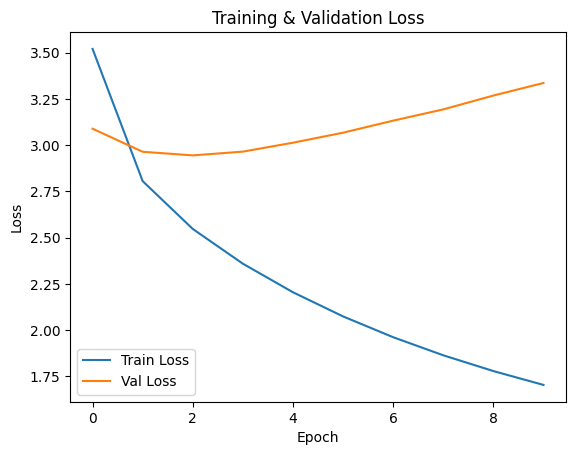

In [66]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()


In [ ]:
import os
IMAGES_DIR = "/kaggle/input/datasets/adityajn105/flickr30k/Images"
print("images:", IMAGES_DIR)

images: /kaggle/input/datasets/adityajn105/flickr30k/Images


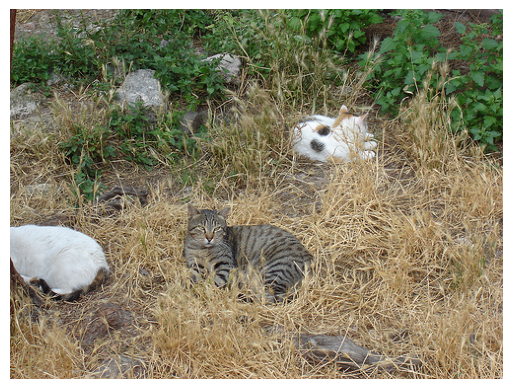

Image: 50030244.jpg
1: the three cats two white with calico accents and a gray tabby are laying in the brown grass
2: the cats are lazily laying in the field of dry grass
Pred (Greedy): a dog is chasing a sheep
Pred (Beam k=3): a white dog and a cat look on


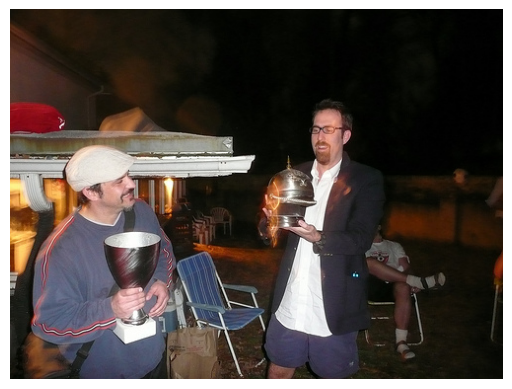

Image: 2276237758.jpg
1: two men outside looking at metalwork objects
2: two men enjoying drinks at an outdoor event
Pred (Greedy): a man in a white shirt is standing in front of a microphone
Pred (Beam k=3): a man in a white shirt is standing in front of a microphone


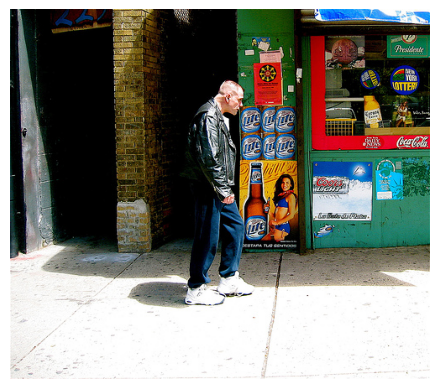

Image: 138482998.jpg
1: a man in jeans and a leather jacket walking by a poster advertising miller lite
2: an elderly man in a black leather jacket is walking down the street
Pred (Greedy): a man in a red shirt and black pants is walking down the street
Pred (Beam k=3): a man in a red shirt and black pants is walking down the street


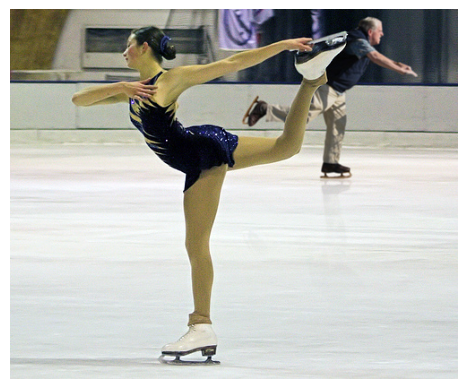

Image: 7520721.jpg
1: a woman figure skater in a blue costume holds her leg in the air by the blade of her skate
2: a lady in a blue outfit is practicing figure skating
Pred (Greedy): a woman in a black dress and black boots is dancing with a man in a black suit and blue shirt
Pred (Beam k=3): a woman in a black dress and a man in a black suit are dancing


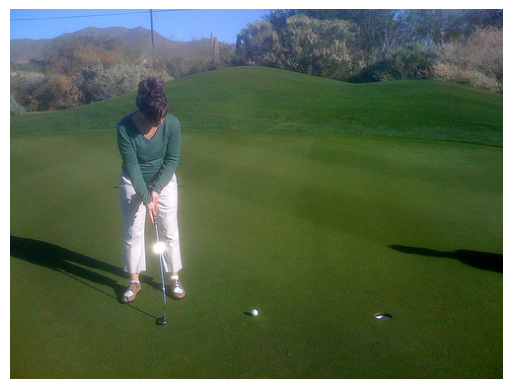

Image: 3125518138.jpg
1: a woman has just taken a stroke on the putting green at a golf course and the ball is on its way to the hole
2: a woman in a green shirt and khaki pants is attempting to hit the golf ball into the hole
Pred (Greedy): a man in a green jacket and jeans is standing on a golf course
Pred (Beam k=3): a man in a green shirt and jeans is standing on a golf course


In [ ]:
from PIL import Image
import random

def clean_for_display(cap):
    cap = cap.replace(START_TOKEN, "").replace(END_TOKEN, "").strip()
    cap = " ".join(cap.split())
    return cap

test_images = sorted(list({img for img, _, _ in test_data}))
random.seed(42)
random_imgs = random.sample(test_images, 5)

for img_name in random_imgs:
    img_path = os.path.join(IMAGES_DIR, img_name)
    im = Image.open(img_path).convert("RGB")

    feat = torch.tensor(features_dict[img_name], dtype=torch.float32)

    pred_greedy = generate_caption_greedy(model, feat, max_len=40)
    pred_beam   = generate_caption_beam(model, feat, max_len=40, k=3)

    gts = image_captions[img_name]
    gts_disp = [clean_for_display(c) for c in gts[:2]]

    plt.figure()
    plt.imshow(im)
    plt.axis("off")
    plt.show()

    print("Image:", img_name)
    print("1:", gts_disp[0])
    if len(gts_disp) > 1:
        print("2:", gts_disp[1])
    print("Pred (Greedy):", pred_greedy)
    print("Pred (Beam k=3):", pred_beam)

In [ ]:
from collections import Counter
import math

def get_ngrams(tokens, n):
    return [tuple(tokens[i:i+n]) for i in range(len(tokens) - n + 1)]

def compute_bleu(references, hypothesis, max_n=4):
    if len(hypothesis) == 0:
        return 0.0
    
    ref_lens = [len(r) for r in references]
    closest_ref_len = min(ref_lens, key=lambda r: (abs(r - len(hypothesis)), r))
    
    if len(hypothesis) < closest_ref_len:
        bp = math.exp(1 - closest_ref_len / len(hypothesis))
    else:
        bp = 1.0
    
   
    precisions = []
    for n in range(1, max_n + 1):
        hyp_ngrams = get_ngrams(hypothesis, n)
        if len(hyp_ngrams) == 0:
            precisions.append(0.0)
            continue
        
        hyp_counts = Counter(hyp_ngrams)
        
        max_ref_counts = Counter()
        for ref in references:
            ref_ngrams = get_ngrams(ref, n)
            ref_counts = Counter(ref_ngrams)
            for ngram in ref_counts:
                max_ref_counts[ngram] = max(max_ref_counts[ngram], ref_counts[ngram])
        
        clipped = sum(min(hyp_counts[ng], max_ref_counts[ng]) for ng in hyp_counts)
        total = sum(hyp_counts.values())
        
        precisions.append(clipped / total if total > 0 else 0.0)
    
    if any(p == 0 for p in precisions):
        return 0.0
    
    log_precisions = [math.log(p) for p in precisions]
    bleu = bp * math.exp(sum(log_precisions) / max_n)
    return bleu

def compute_token_metrics(references, hypothesis):

    hyp_tokens = set(hypothesis)
    ref_tokens = set()
    for ref in references:
        ref_tokens.update(ref)
    
    if len(hyp_tokens) == 0:
        precision = 0.0
    else:
        precision = len(hyp_tokens & ref_tokens) / len(hyp_tokens)
    
    if len(ref_tokens) == 0:
        recall = 0.0
    else:
        recall = len(hyp_tokens & ref_tokens) / len(ref_tokens)
    
    if precision + recall == 0:
        f1 = 0.0
    else:
        f1 = 2 * precision * recall / (precision + recall)
    
    return precision, recall, f1


test_images_unique = sorted(list({img for img, _, _ in test_data}))
bleu_scores = []
precisions = []
recalls = []
f1_scores = []

def tokenize_caption(cap):
    """Clean and tokenize a caption string."""
    cap = cap.replace(START_TOKEN, "").replace(END_TOKEN, "").strip()
    return cap.split()

for i, img_name in enumerate(test_images_unique):
    feat = torch.tensor(features_dict[img_name], dtype=torch.float32)
    
    pred_caption = generate_caption_greedy(model, feat, max_len=40)
    pred_tokens = pred_caption.split()
    
    refs = image_captions[img_name]
    ref_token_lists = [tokenize_caption(r) for r in refs]
    
    bleu = compute_bleu(ref_token_lists, pred_tokens, max_n=4)
    bleu_scores.append(bleu)
    
    p, r, f1 = compute_token_metrics(ref_token_lists, pred_tokens)
    precisions.append(p)
    recalls.append(r)
    f1_scores.append(f1)

print(f"\nBLEU-4 Score:       {sum(bleu_scores)/len(bleu_scores):.4f}")
print(f"  Precision:        {sum(precisions)/len(precisions):.4f}")
print(f"  Recall:           {sum(recalls)/len(recalls):.4f}")
print(f"  F1-score:         {sum(f1_scores)/len(f1_scores):.4f}")



BLEU-4 Score:       0.1010
  Precision:        0.6019
  Recall:           0.1807
  F1-score:         0.2724
